In [18]:
!pip install pdfplumber
!pip install pyvis
!pip install openai
!pip install pypdf
!pip uninstall fitz # Uninstall the conflicting fitz package.
!pip install pymupdf # Install PyMuPDF which includes the correct fitz module.
!pip install spacy
import spacy

In [28]:
!git add

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	Docs/
	https:/
	nlp3LLM.csv
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [19]:
nlp = spacy.load("en_core_web_sm")

In [23]:
from pypdf import PdfReader
import os
start='abstract'
end='references'

start_page=0
main_dir="/content/Docs/"
def find_index(text,target):
    try:
        return text.index(target)
    except:
        return -1

for files in os.listdir(main_dir):
    passage=""
    found=False
    path=main_dir+files
    if files[-3:]!="pdf":
        continue
    reader = PdfReader(path)
    number_of_pages = len(reader.pages)
    for page_num in range(number_of_pages):
        page = reader.pages[page_num]
        text = [texts.lower() for texts in page.extract_text().split()]
        start_idx=find_index(text,start)+1
        end_idx=find_index(text,end)
        if found:
            if start_idx == -1 and end_idx==-1:
                passage += " ".join(text)
            elif end_idx != -1 and start_idx == -1:
                passage += " ".join(text[:end_idx])
            else:
                passage += " ".join(text[start_idx:end_idx])
        elif not found:
            if start_idx != -1 and end_idx != -1:
                found=True
                passage += " ".join(text[start_idx:end_idx])
            elif start_idx == -1 and end_idx != -1:
                found=True
                passage += " ".join(text[:end_idx])
            elif start_idx == -1 and end_idx == -1:
                continue
            else:
                found=True
                passage += " ".join(text[start_idx:])
    with open(main_dir+"text/"+files[:-3]+".txt", 'w') as f:
        f.write(passage)




direct pdf w/ llm

In [20]:
API_KEY=''
modeltype= 'gpt-4-turbo-preview'

In [102]:
#pdf llm
from openai import OpenAI

client= OpenAI( api_key= API_KEY)

for filename in os.listdir("/content/Docs"):
  filename= "/content/Docs/" + filename
  assistant_name= 'Clinicial Assistant'

  instructions= """
  You are to extract important entities, their definitions, overarching ideas,  and their relationships between one another from this paper. Don't copy the sentence
  word for word and split it up. Understand the sentence and determine the relationships between the subject and objects

  The idea is that these relationships can be pieced together into a knowledge graph that a clinican can trace. Keep this in mind as you extract.

  Relatioships should be
    1. treatment :  IPT --> treatment for -> depression
    2. symptom: sadness -> symptom of -> depression
    3. example: medA --> example of -> antidepressant
    4. not effective: medA -> not effective for --> depressin
    5. effective: medA -> effective for -> depression
    6. more effective: medA -> more effective than -> medB
    7. less effective: medA -> less effective than -> medB
    8. side effects: sneezing --> side effect of -> medA

  Example:  "Sertraline might be the best choice when starting treatment for  moderate  to  severe  major  depression  in  adults  "
  gets converted into "subj": "Sertraline", "rel": "treatment", "object1": "Adults Moderate to severe major depression"

  Present 1 dataframe in an easily readable and visually appealing format.
  The dataframe should explain the relationships between all subjects.
  It should have a minimum of 3 headers, subj, rel, obj
  If you have object2 as a header, you must have a non-empty rel2 as a header. If thats not possible place the relationship in the next row


  return a pandas dataframe structure called "paper1"
  Avoid entities and relationships that are more than a few words. If you need to list multiple drug names or treatments, list them in different rows

  """

  assistant= client.beta.assistants.create(
  name= assistant_name,
  instructions= instructions,
  model= modeltype,
  tools= [{"type":"file_search"}])

  message_file= client.files.create(
  file=open(filename, "rb"),
  purpose="assistants")
  thread= client.beta.threads.create(
    messages=[
        {
            "role":"user",
            "content": content,
            "attachments":[
                {"file_id": message_file.id,
                "tools":[{"type":"file_search"}]}
            ],

        }
    ]
                 )

  run= client.beta.threads.runs.create_and_poll(thread_id= thread.id, assistant_id= assistant.id)

  messages= list(client.beta.threads.messages.list(thread_id=thread.id, run_id= run.id))
  message_content= messages[0].content[0].text
  annotations= message_content.annotations
  citations=[]
  for index, annotation in enumerate(annotations):
              message_content.valye= message_content.value .replace(annotation.text,""). replace(".", "")
              if file_citation :=getattr(annotations, "file_citation", None):
                  cited_file= client.files.retrieve(file_citation.file.id)
                  citations.append(f"[{index}] {cited_file.filename}")
  cand_name= message_content.value.replace(".", ""). strip()
  print(cand_name)

To synthesize the data extracted from the provided documentation into a structured format suitable for a knowledge graph for clinical use, I've created a dataframe reflecting the relationships between subjects, such as antidepressants, their efficacy, their comparability to other treatments, their acceptability, and side effects 

Given the extensive data and the complexity of the relationships, below is a simplified summarization reflecting key relationships found within the document:

```plaintext
subj            | rel                | obj
----------------------------------------------------------
Escitalopram    | more effective than| Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine
Mirtazapine     | more effective than| Fluoxetine
Sertraline      | more effective than| Fluoxetine
Venlafaxine     | more effective than| Fluoxetine
Reboxetine      | less effective than| All studied antidepressants
Duloxetine      | less tolerated than| Escitalopram, Sertraline
Paroxetine   

In [87]:
data1 = {
    "subj": [
        "Mirtazapine", "Venlafaxine", "Sertraline",
        "Escitalopram", "Reboxetine", "Duloxetine", "Fluoxetine",
        "Fluvoxamine", "Paroxetine", "Bupropion", "Citalopram",
        "Milnacipran"
    ],
    "rel": [
        "more effective than", "more effective than", "more effective than",
        "more effective than", "less effective than", "less well tolerated than",
        "less effective than", "less well tolerated than", "less well tolerated than",
        "better tolerated than", "more effective than", "more effective than"
    ],
    "object1": [
        "Fluoxetine", "Fluoxetine", "Duloxetine and Fluvoxamine",
        "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine", "all other 11 antidepressants",
        "Escitalopram and Sertraline", "many other antidepressants", "Citalopram, Escitalopram, Sertraline",
        "Escitalopram and Sertraline", "Duloxetine, Fluvoxamine, Paroxetine, Reboxetine",
        "Fluoxetine", "Fluvoxamine"
    ]
}
data2 = {
    "subj": ["MAOIs", "TCAs", "ECT", "SSRIs", "Nefazodone", "Trazodone", "Vortioxetine", "Ketamine", "MAOIs", "TCAs", "Bupropion", "MAOIs", "SSRIs", "SSRIs", "Escitalopram", "Duloxetine", "Venlafaxine"],
    "rel": ["example of", "effective for", "treatment for", "less effective than", "side effect of", "side effect of", "effective for", "effective for", "not effective for", "more effective than", "side effects", "treatment option when", "effective for", "side effects", "effective for", "effective for", "more effective than"],
    "object1": ["antidepressant", "depression with atypical features", "depression", "TCAs for hospitalized patients", "hepatotoxicity", "somnolence", "depression", "resistant depression and acute suicidal ideation", "depression resistant to SSRIs and SNRIs", "SSRIs for hospitalized patients", "minimal weight gain or even weight loss; risk for seizures", "ECT is contraindicated", "major depressive disorder with high levels of anxiety", "several minor side effects including sexual dysfunction", "major depressive disorder", "major depressive disorder", "SSRIs"],
    "rel2": ["side effects", "treatment option when", "", "no difference in", "", "", "", "", "", "", "", "", "", "", "", "", ""],
    "object2": ["numerous including hepatotoxicity and hypertensive crises", "other pharmacotherapies have not succeeded", "", "outpatients less severely ill", "", "", "", "", "", "", "", "", "", "", "", "", ""]
}

data3 = {
    "subj": ["Anxious Depression", "Citalopram", "Citalopram + Benzodiazepine", "Bupropion (SR)", "Sertraline", "Venlafaxine (XR)", "Citalopram + Bupropion", "Citalopram + Buspirone", "Side Effects"],
    "rel": ["less likely to", "treatment for", "effective for", "effective for", "effective for", "effective for", "effective for", "effective for", "greater in"],
    "object1": ["achieve remission than Nonanxious Depression", "Depression", "Anxious Depression", "Nonanxious Depression", "Nonanxious Depression", "Nonanxious Depression", "Anxious Depression", "Anxious Depression", "Anxious Depression"],
    "rel2": ["", "", "leads to", "", "", "", "", "", "associated with"],
    "object2": ["", "", "remission of symptoms", "", "", "", "", "", "anxious features in Depression"]
}

d1=pd.DataFrame(data1)
d2=pd.DataFrame(data2)
d3=pd.DataFrame(data3)
pd.concat([d1,d2,d3]).reset_index().drop(columns=['index']).to_csv('pdfLLM.csv')

In [70]:
data = {"subj": ["Venlafaxine", "Escitalopram", "Mirtazapine", "Reboxetine", "Citalopram", "Sertraline", "Duloxetine", "Fluoxetine", "Paroxetine"],
        "rel": ["effective for", "effective for", "effective for", "effective for", "effective for", "effective for", "effective for", "effective for", "effective for"],
        "object1": ["Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression"],
        "rel2": ["more effective than", "less effective than", "more effective than", "more effective than",
                 "less effective than", "more effective than", "less effective than", "more effective than", "more effective than"],
         "object2": ["Bupropion", "Duloxetine", "Fluoxetine", "Fluoxetine", "Sertraline",
                     "Fluoxetine", "Escitalopram", "Milnacipran", "Fluoxetine"],
        "rel3": ["side effect of", "side effect of", "side effect of", "side effect of", "side effect of", "side effect of", "side effect of", "side effect of", "side effect of"],
        "object3": ["N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A"]}

In [71]:
pd.DataFrame(data)

,subj,rel,object1,rel2,object2,rel3,object3
0,Venlafaxine,effective for,Depression,more effective than,Bupropion,side effect of,N/A
1,Escitalopram,effective for,Depression,less effective than,Duloxetine,side effect of,N/A
2,Mirtazapine,effective for,Depression,more effective than,Fluoxetine,side effect of,N/A
3,Reboxetine,effective for,Depression,more effective than,Fluoxetine,side effect of,N/A
4,Citalopram,effective for,Depression,less effective than,Sertraline,side effect of,N/A
5,Sertraline,effective for,Depression,more effective than,Fluoxetine,side effect of,N/A
6,Duloxetine,effective for,Depression,less effective than,Escitalopram,side effect of,N/A
7,Fluoxetine,effective for,Depression,more effective than,Milnacipran,side effect of,N/A
8,Paroxetine,effective for,Depression,more effective than,Fluoxetine,side effect of,N/A


nlp processing w/ llm

In [21]:
import fitz,os,spacy
import pandas as pd
texts=[]
# Opening the PDF file
for doc in os.listdir('/content/Docs/'):
  doc=fitz.open("/content/Docs/"+doc)
# Extracting text from all pages
  all_text = []
  for page_num in range(0,len(doc),3):
    tex=""
    for p in range(page_num, page_num+3):
      if p >= len(doc):
        break
      page = doc[p]
      text = page.get_text().replace('\n', ' ').lower()
      docs=nlp(text)
      text=" ".join([token.lemma_ for token in docs])
      tex += text
    all_text.append([page_num + 1, tex])
  df = pd.DataFrame(all_text, columns=['Page', 'Text'])
  for text in df['Text'].to_list():
    texts.append(text)

In [16]:
texts

['article 746   www.thelancet.com    vol 373    february 28 , 2009 comparative eﬃ   cacy and acceptability of 12 new - generation   antidepressant : a multiple - treatment meta - analysis andrea cipriani , toshiaki a furukawa , georgia salanti , john r gedde , julian p t higgins , rachel churchill , norio watanabe , atsuo nakagawa ,   ichiro m omori , hugh mcguire , michele tansella , corrado barbui summary background conventional meta - analysis have show inconsistent result for eﬃ   cacy of second - generation   antidepressant . we therefore do a multiple - treatment meta - analysis , which account for both direct and indirect   comparison , to assess the eﬀ ect of 12 new - generation antidepressant on major depression . method we systematically review 117 randomise control trial ( 25 928 participant ) from 1991 up to   nov 30 , 2007 , which compare any of the follow antidepressant at therapeutic dose range for the acute treatment   of unipolar major depression in adult : bupropion ,

In [22]:
from openai import OpenAI
client= OpenAI( api_key= API_KEY)

import json
for t in texts:
  prompt_llm= """
  json: You are to extract important entities, their definitions, overarching ideas,  and their relationships between one another from this paper. Don't copy the sentence
  word for word and split it up. Understand the sentence and determine the relationships between the subject and objects

  The idea is that these relationships can be pieced together into a knowledge graph that a clinican can trace. Keep this in mind as you extract.

  Relatioships should be
    1. treatment :  IPT --> treatment for -> depression
    2. symptom: sadness -> symptom of -> depression
    3. example: medA --> example of -> antidepressant
    4. not effective: medA -> not effective for --> depressin
    5. effective: medA -> effective for -> depression
    6. more effective: medA -> more effective than -> medB
    7. less effective: medA -> less effective than -> medB
    8. side effects: sneezing --> side effect of -> medA

  Example:  "Sertraline might be the best choice when starting treatment for  moderate  to  severe  major  depression  in  adults  "
  gets converted into "subj": "Sertraline", "rel": "treatment", "object1": "Adults Moderate to severe major depression"

  Present 1 dataframe in an easily readable and visually appealing format.
  The dataframe should explain the relationships between all subjects.
  It should have a minimum of 3 headers, subj, rel, obj
  If you have object2 as a header, you must have a non-empty rel2 as a header. If thats not possible place the relationship in the next row


  return a pandas dataframe structure called "paper1"
  Avoid entities and relationships that are more than a few words. If you need to list multiple drug names or treatments, list them in different rows


  """

  prompt=f"Using this information: {t}, answer the following question: {prompt_llm}"

  chat_completion=client.chat.completions.create(
      messages=[
          {
              "role": "system",
              "content": prompt_llm,
          },
          {
              "role": "user",
              "content": prompt,
          }
      ],
  model= modeltype,
    )
  resp=chat_completion.choices[0].message.content
  start_idx=resp.find("data = ")
  if resp[start_idx+7] == '[':
    end_idx=resp[start_idx:].find(']')
  else:
    end_idx=resp[start_idx:].find('}')
  resp=resp[start_idx+7:start_idx+end_idx+1]

  print(resp)
  print("\n\n\n")





data = {
    "subj": [
        "Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline",
        "Duloxetine", "Fluoxetine", "Fluvoxamine", "Paroxetine",
        "Reboxetine", "Escitalopram", "Sertraline", "Sertraline"
    ],
    "rel": [
        "more effective than", "more effective than", "more effective than", "more effective than",
        "less effective than", "less effective than", "less effective than", "less effective than",
        "less effective than", "effective for", "effective for", "treatment"
    ],
    "obj": [
        "Duloxetine", "Duloxetine", "Duloxetine", "Duloxetine",
        "all other tested antidepressants", "all other tested antidepressants", "all other tested antidepressants", "all other tested antidepressants",
        "all other tested antidepressants", "depression", "depression", "Adult moderate to severe major depression"
    ],
}









data = {
    "subj": [
        "Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline",
        "Escitalopram

In [23]:
data1 = {
    "subj": [
        "Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline",
        "Duloxetine", "Fluoxetine", "Fluvoxamine", "Paroxetine",
        "Reboxetine", "Escitalopram", "Sertraline", "Sertraline"
    ],
    "rel": [
        "more effective than", "more effective than", "more effective than", "more effective than",
        "less effective than", "less effective than", "less effective than", "less effective than",
        "less effective than", "effective for", "effective for", "treatment"
    ],
    "obj": [
        "Duloxetine", "Duloxetine", "Duloxetine", "Duloxetine",
        "all other tested antidepressants", "all other tested antidepressants", "all other tested antidepressants", "all other tested antidepressants",
        "all other tested antidepressants", "depression", "depression", "Adult moderate to severe major depression"
    ],
}









data2 = {
    "subj": [
        "Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline",
        "Escitalopram", "Sertraline", "Bupropion", "Citalopram",
        "Reboxetine", "Fluvoxamine", "Paroxetine", "Duloxetine",
        "Reboxetine", "Sertraline", "Escitalopram"
     ],
    "rel": [
        "effective", "effective", "effective", "effective",
        "tolerated", "tolerated", "tolerated", "tolerated",
        "not effective", "not effective", "not effective", "not effective",
        "less tolerated", "more effective", "more effective"
     ],
    "obj": [
        "Depression", "Depression", "Depression", "Depression",
        "Antidepressant use", "Antidepressant use", "Antidepressant use", "Antidepressant use",
        "Depression", "Depression", "Depression", "Depression",
        "Antidepressant use", "Than other new-generation drugs", "Than other new-generation drugs"
    ]
}




data3 = {
    'subj': ['Sertraline', 'Milnacipran', 'Venlafaxine', 'SSRIs', 'Milnacipran', 'Venlafaxine', 'Escitalopram', 'Venlafaxine', 'Bupropion', 'Fluoxetine'],
    'rel': ['example', 'effective', 'effective', 'effective', 'more effective than', 'more effective than', 'effective', 'less effective than', 'treatment', 'treatment'],
    'obj': ['antidepressant', 'depression', 'depression', 'depression', 'SSRIs', 'SSRIs', 'major depressive disorder', 'Duloxetine', 'major depressive disorder', 'major depressive disorder']
}




data4 = [
    {"subj": "extended-release bupropion hydrochloride", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "extended-release venlafaxine hydrochloride", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "wellbutrin (bupropion hcl) sustain release", "rel": "treatment", "obj": "moderate to severe recurrent major depression"},
    {"subj": "fluoxetine", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "paroxetine", "rel": "treatment", "obj": "major depressive disorder with anxiety"},
    {"subj": "citalopram", "rel": "treatment", "obj": "major depressive disorder with anxiety"},
    {"subj": "duloxetine", "rel": "treatment", "obj": "acute treatment of major depression"},
    {"subj": "escitalopram", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "sertraline", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "escitalopram", "rel": "effective", "obj": "major depressive disorder"},
    {"subj": "fluoxetine vs. paroxetine", "rel": "more effective than", "obj": "no clear winner; both treat major depressive disorder"},
    {"subj": "paroxetine", "rel": "effective", "obj": "major depressive disorder with regard to antidepressant efficacy"},
    {"subj": "fluoxetine", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "Selective Serotonin Reuptake Inhibitors (SSRIs)", "rel": "example", "obj": "antidepressant"}
]




data5 = {
    "subj": [
        "SSRIs",
        "ECT",
        "MAOIs",
        "TCAs",
        "Sertraline",
        "Fluoxetine",
        "Venlafaxine",
        "Duloxetine",
        "Reboxetine",
        "Bupropion",
        "Nefazodone",
        "Trazodone"
    ],
    "rel": [
        "treatment",
        "treatment",
        "less effective",
        "more effective",
        "treatment",
        "example of",
        "example of",
        "example of",
        "less effective",
        "effective",
        "effective",
        "not effective"
    ],
    "obj": [
        "Depression",
        "Depression in specific situations",
        "Depression compared to TCAs",
        "Severe MDD compared to SSRIs",
        "Moderate to severe major depression",
        "Antidepressant",
        "SNRIs",
        "SNRIs",
        "Depression compared to SSRIs",
        "Depression with low to moderate anxiety",
        "Depression comparable to SSRIs",
        "As an antidepressant in contemporary practice"
    ]
}




data6 = {
    "subj": [
        "Mirtazapine",
        "Mirtazapine",
        "Vilazodone",
        "Vortioxetine",
        "Vortioxetine",
        "Citalopram",
        "Citalopram",
        "Ketamine",
        "Ketamine",
        "Esketamine",
        "Esketamine",
        "Esketamine",
        "Cognitive Behavioral Therapy",
        "Interpersonal Therapy",
        "Cognitive Behavioral Analysis System of Psychotherapy"
    ],
    "rel": [
        "effective",
        "side effects",
        "side effects",
        "effective",
        "side effects",
        "tolerable",
        "side effects",
        "effective",
        "side effects",
        "approved for",
        "side effects",
        "risk",
        "effective",
        "treatment for",
        "recommended for"
    ],
    "obj": [
        "Depression",
        "Nausea, vomiting, weight gain",
        "Sexual dysfunction less common",
        "Depression, cognitive impairments",
        "Nausea most common side effect",
        "Depression more tolerable",
        "Nausea, vomiting, sexual dysfunction, sedation, priapism, cardiotoxicity",
        "Resistant depression, acute suicidal ideation",
        "Dizziness, neurotoxicity, cognitive dysfunction, blurred vision, psychosis, dissociation, urological dysfunction, restlessness, headache, cardiovascular symptoms",
        "Treatment-resistant depression",
        "Potential for abuse",
        "High",
        "Depression",
        "Depression",
        "Chronic depression"
    ]
}




data7 = [
    {"subj": "CBT", "rel": "treatment", "obj": "depression"},
    {"subj": "Behavioral activation", "rel": "effective for", "obj": "depression"},
    {"subj": "Acceptance and Commitment Therapy", "rel": "effective for", "obj": "depression"},
    {"subj": "Schema therapy", "rel": "as effective as", "obj": "CBT", "rel2": "treatment", "obj2": "depression"},
    {"subj": "Physical exercise", "rel": "effective for", "obj": "depression"},
    {"subj": "IPT", "rel": "treatment", "obj": "depression"},
    {"subj": "Problem-solving therapy", "rel": "treatment", "obj": "depression"},
    {"subj": "Marital and Family Therapy", "rel": "treatment", "obj": "depression"},
    {"subj": "Group therapy", "rel": "effective for", "obj": "depression"},
    {"subj": "MBCT", "rel": "reduces relapse", "obj": "depression"},
    {"subj": "ECT", "rel": "most effective treatment", "obj": "major unipolar depression"},
    {"subj": "rTMS", "rel": "more effective than", "obj": "placebo", "rel2": "treatment", "obj2": "depression"},
    {"subj": "tDCS", "rel": "less effective than", "obj": "antidepressants and rTMS", "rel2": "treatment", "obj2": "depression"},
]




data8 = {
    "subj": ["tdcs", "VNS", "DBS", "Magnetic seizure therapy", "Phototherapy", "ECT", "rTMS", "tdcs", "Antidepressants", "Psychotherapy", "Somatic therapies", "ECT", "VNS", "Psychotherapy", "Antidepressants"],
    "rel": ["treatment", "treatment", "effective", "effective", "effective", "effective", "effective", "treatment", "effective", "effective", "effective", "treatment", "side effects", "treatment", "treatment"],
    "obj": ["Depression", "Resistant Depression", "Resistant Depression", "Psychiatric Disorders", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Certain Forms of Depression", "Few Cardiac Effects", "Depression", "Depression"],
    "rel2": [None, None, "after 6 months", "on depressive symptoms", "for seasonal and non-seasonal", None, "with well-tolerated profile", "for remote treatment", "new molecules studied", "personalize and simplify", "need confirmed indication", "most documented", "compared to", None, "ongoing research"],
    "obj2": [None, None, "60% response rate", None, None, None, None, "and assessment", None, None, None, None, "other treatments", None, None]
}




data9 = {
    'subj': ['Citalopram', 'Reboxetine', 'Bupropion', 'Venlafaxine', 'Trazodone', 'Nefazodone', 'Vortioxetine',
             'Esketamine', 'Mirtazapine', 'Ketamine', 'Intranasal Esketamine', 'SSRIs', 'Nefazodone', 'Riluzole'],
    'rel': ['effective', 'effective', 'effective', 'effective', 'effective', 'effective', 'effective',
            'effective', 'effective', 'effective', 'effective', 'effective',
            'side effects', 'effective'],
    'obj': ['Depression', 'Depression', 'Depression with high level of anxiety (anxious depression)', 'Major Depression',
            'Major Depressive Disorder', 'Major Depressive Disorder', 'Major Depressive Disorder',
            'Treatment-Resistant Depression', 'Major Depressive Disorder', 'Treatment-Resistant Depression', 'Treatment-Resistant Depression',
            'Acute Treatment of Adults with Major Depressive Disorder',
            'Clinical Hepatotoxicity', 'Moderate-to-Severe Major Depressive Disorder']
}




data10 = {
    'subj': ['Exercise',
             'Psychotherapy',
             'Psychoeducation',
             'Electroconvulsive therapy',
             'Electroconvulsive therapy',
             'Electroconvulsive therapy',
             'rtms',
             'rtms',
             'Transcranial Direct Current Stimulation (tDCS)',
             'Vagus nerve stimulation',
             'Vagus nerve stimulation',
             'Deep brain stimulation',
             'Magnetic seizure therapy',
             'Light therapy',
             'Sleep deprivation'],
    'rel': ['effective for',
            'effective for',
            'effective for',
            'effective for',
            'more effective than',
            'side effect of',
            'effective for',
            'not effective for',
            'effective for',
            'effective for',
            'not effective for',
            'effective for',
            'effective for',
            'effective for',
            'effective for'],
    'obj': ['Depression',
            'Depression',
            'Depression',
            'Severe major depression',
            'Medication alone',
            'Dementia risk',
            'Depression',
            'Certain depression types',
            'Major Depressive Disorder',
            'Treatment-Resistant Depression',
            'Some depression cases',
            'Treatment-resistant depression',
            'Refractory major depression',
            'Mood disorders',
            'Bipolar depression']
}









data11 = {
    "subj": [
        "Citalopram", "Anxious depression", "Nonanxious depression", "Bupropion",
        "Sertraline", "Venlafaxine", "Citalopram", "Buspirone", "Anxious depression",
        "Anxious depression", "Nonanxious depression", "Major depressive disorder",
        "Anxiety", "Anxious depression", "Nonanxious depression", "Antidepressant treatment"
    ],
    "rel": [
        "treatment", "outcome", "outcome", "example of", "example of",
        "example of", "combined with", "combined with", "symptom of", "associated with",
        "associated with", "symptom of", "symptom of", "more likely to be", "less likely to be",
        "less effective for"
    ],
    "obj": [
        "Major Depressive Disorder", "worse than nonanxious", "better than anxious", "Antidepressant",
        "Antidepressant", "Antidepressant", "Bupropion", "Buspirone", "Major Depressive Disorder",
        "Unemployment", "Employment", "Depression", "Depression", "Unemployed", "Employed",
        "Anxious depression"
    ]
}




data12= {
    "subj": ["Citalopram", "Anxious depression", "Nonanxious depression", "Anxious depression", "Citalopram", "Bupropion (SR)", "Sertraline", "Venlafaxine (XR)", "Citalopram + Bupropion (SR)", "Citalopram + Buspirone", "Anxious depression", "Nonanxious depression"],
    "rel": ["effective for", "less effective for", "more effective for", "effective for", "treatment", "example of", "example of", "example of", "example of", "example of", "associated with", "associated with"],
    "obj": ["Depression", "Citalopram treatment", "Citalopram treatment", "Increased side effects", "Major depressive disorder", "Antidepressant", "Antidepressant", "Antidepressant", "Augmentation option", "Augmentation option", "Increased suicidal ideation", "Lower hospitalization for general medical condition"]
}




data13 = {
    "subj": [
        "Anxious depression",
        "Nonanxious depression",
        "Side effects",
        "Anxious depression",
        "Citalopram",
        "Citalopram plus bupropion",
        "Citalopram plus buspirone",
        "Benzodiazepine",
        "Citalopram",
        "Antidepressant treatment",
        "Ms. D",
        "Benzodiazepine",
    ],
    "rel": [
        "associated with",
        "associated with",
        "more frequent and intense in",
        "treatment effectiveness",
        "treatment for",
        "treatment effective for",
        "treatment effective for",
        "effective for",
        "side effect of",
        "not effective for",
        "symptom of",
        "side effect improvement in",
    ],
    "obj": [
        "greater side effect burden than nonanxious depression",
        "less serious adverse events than anxious depression",
        "anxious depression",
        "less likely to achieve remission",
        "major depressive disorder",
        "anxious depression",
        "anxious depression",
        "anxiety symptoms in anxious depression",
        "dry mouth, insomnia, and nervousness",
        "anxious depression in some cases",
        "depression with generalized anxiety",
        "insomnia and agitation in anxious depression",
    ],
}




data14 = {
    "subj": ["IPT", "Sadness", "Sertraline", "Bupropion-SR", "Sertraline", "Venlafaxine-XR", "Bupropion-SR", "Citalopram"],
    "rel": ["treatment", "symptom", "example", "example", "effective", "more effective", "not effective", "effective"],
    "obj": ["Depression", "Depression", "Antidepressant", "Antidepressant", "Depression", "Sertraline for Depression", "Depression after SSRIs", "Major Depression"],
}


data=[data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14]
for i,_ in enumerate(data):
  data[i]=pd.DataFrame(data[i])
pd.concat(data).reset_index().drop(columns=['index']).to_csv('nlp3LLM.csv')


In [99]:
data1 = {
    "subj": ["Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline", "Reboxetine", "Escitalopram", "Sertraline", "Sertraline"],
    "rel": ["more effective than", "more effective than", "more effective than", "more effective than",
            "less effective than", "effective for", "effective for", "treatment"],
    "obj": ["Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine",
            "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine",
            "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine",
            "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine",
            "All other tested antidepressants",
            "Major Depression", "Major Depression", "Adults Moderate to Severe Major Depression"],
}




data2 = {
    "subj": [
        "Acute treatment", "Response rate", "Treatment discontinuation", "Dosing classification",
        "Bupropion", "Citalopram", "Duloxetine", "Escitalopram", "Fluoxetine", "Fluvoxamine",
        "Milnacipran", "Mirtazapine", "Paroxetine", "Reboxetine", "Sertraline", "Venlafaxine"
    ],
    "rel": [
        "defined for", "indicator of", "indicator of", "used for",
        "example of", "example of", "example of", "example of", "example of", "example of",
        "example of", "example of", "example of", "example of", "example of", "example of"
    ],
    "obj": [
        "8-week efficacy and acceptability analyses", "acute-treatment efficacy", "acceptability", "equivalence of dosage among antidepressants",
        "antidepressant", "antidepressant", "antidepressant", "antidepressant", "antidepressant", "antidepressant",
        "antidepressant", "antidepressant", "antidepressant", "antidepressant", "antidepressant", "antidepressant"
    ]
}




data3 = {
    "subj": [
        "Random-effects model",
        "Bayesian framework",
        "Fluoxetine",
        "Intention-to-treat analysis",
        "Incoherence"
    ],
    "rel": [
        "used in",
        "used in",
        "reference for",
        "method for",
        "disagreement between"
    ],
    "obj": [
        "pair-wise meta-analysis",
        "comparing treatments within a",
        "comparing antidepressants",
        "treatment analysis",
        "direct and indirect evidence"
    ]
}




data4 = {
    'subj': ['bupropion', 'fluoxetine', 'paroxetine', 'sertraline', 'venlafaxine', 'citalopram', 'fluvoxamine', 'mirtazapine', 'reboxetine', 'duloxetine', 'milnacipran', 'mirtazapine', 'reboxetine', 'sertraline*', 'venlafaxine'],
    'rel': ['less effective than', 'less effective than', 'less effective than', 'effective for', 'effective for', 'more effective than', 'less effective than', 'more effective than', 'more effective than', 'less effective than', 'less effective than', 'less effective than', 'more effective than', 'more effective than', 'more effective than'],
    'obj': ['escitalopram', 'escitalopram', 'escitalopram', 'depression', 'depression', 'escitalopram', 'escitalopram', 'escitalopram', 'escitalopram', 'escitalopram', 'escitalopram', 'depression', 'escitalopram', 'depression', 'depression']
}




data5 = {
    "subj": ["Fluoxetine", "Milnacipran", "Mirtazapine", "Paroxetine", "Sertraline", "Venlafaxine", "Fluoxetine", "Milnacipran", "Mirtazapine", "Paroxetine", "Sertraline", "Venlafaxine", "Reboxetine"],
    "rel": ["not effective for", "not effective for", "not effective for", "not effective for", "not effective for", "not effective for", "effective for", "effective for", "effective for", "effective for", "effective for", "effective for", "not effective for"],
    "obj": ["Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression", "Depression"],
}




data6 = {
    "subj": ["Escitalopram", "Citalopram", "Mirtazapine", "Sertraline", "Venlafaxine", "Reboxetine", "Duloxetine", "Duloxetine", "Fluvoxamine", "Venlafaxine", "Reboxetine", "Escitalopram", "Sertraline"],
    "rel": ["more effective than", "more effective than", "more effective than", "more effective than", "more effective than", "less effective than", "less well tolerate than", "less well tolerate than", "less well tolerate than", "less well tolerate than", "less well tolerate than", "well tolerate than", "well tolerate than"],
    "obj": ["Citalopram", "Reboxetine and Paroxetine", "Fluoxetine and Venlafaxine", "Fluoxetine", "Fluoxetine and Fluvoxamine", "All other antidepressants", "Escitalopram and Sertraline", "Escitalopram and Sertraline", "Citalopram, Escitalopram, Sertraline", "Escitalopram", "Many other antidepressants", "Duloxetine, Fluvoxamine, Paroxetine, Reboxetine", "Duloxetine, Fluvoxamine, Paroxetine, Reboxetine"]
}




data7 = {
    "subj": [
        "Fluoxetine", "Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline",
        "Escitalopram", "Sertraline", "Bupropion", "Citalopram",
        "Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline", "Citalopram"
    ],
    "rel": [
        "more effective than", "more effective than", "more effective than", "more effective than", "more effective than",
        "well tolerated than", "well tolerated than", "well tolerated than", "well tolerated than",
        "effective for", "effective for", "effective for", "effective for", "effective for"
    ],
    "obj": [
        "Reboxetine", "Reboxetine", "Reboxetine", "Reboxetine", "Reboxetine",
        "Other antidepressants", "Other antidepressants", "Other antidepressants", "Other antidepressants",
        "Depression", "Depression", "Depression", "Depression", "Depression"
    ]
}




data8 = {
    'subj': ['Mirtazapine', 'Escitalopram', 'Venlafaxine', 'Sertraline', 'Duloxetine', 'Fluoxetine',
             'Fluvoxamine', 'Paroxetine', 'Reboxetine', 'Escitalopram', 'Sertraline',
             'Citalopram', 'Bupropion', 'Reboxetine', 'Sertraline', 'Reboxetine'],
    'rel': ['more effective than', 'more effective than', 'more effective than', 'more effective than',
            'less effective than', 'less effective than', 'less effective than', 'less effective than',
            'less effective than', 'effective for', 'effective for', 'well tolerated than',
            'well tolerated than', 'least tolerated', 'best choice treatment for', 'not effective for'],
    'obj': ['Duloxetine/Fluoxetine/Fluvoxamine/Paroxetine/Reboxetine',
            'Duloxetine/Fluoxetine/Fluvoxamine/Paroxetine/Reboxetine',
            'Duloxetine/Fluoxetine/Fluvoxamine/Paroxetine/Reboxetine',
            'Duloxetine/Fluoxetine/Fluvoxamine/Paroxetine/Reboxetine',
            'Mirtazapine/Escitalopram/Venlafaxine/Sertraline',
            'Mirtazapine/Escitalopram/Venlafaxine/Sertraline',
            'Mirtazapine/Escitalopram/Venlafaxine/Sertraline',
            'Mirtazapine/Escitalopram/Venlafaxine/Sertraline',
            'All others', 'Major Depression', 'Major Depression', 'Other new-generation antidepressants',
            'Other new-generation antidepressants', 'All others', 'Moderate to severe major depression', 'Major Depression'],
}




data9 = {
    "subj": ["Efficacy Assessment", "Systematic Reviews", "Antidepressants Response", "Placebo-Controlled Trials", "Placebo-Controlled Trials", "Sertraline", "Sponsorship Bias"],
    "rel": ["determined by", "struggle with", "needs", "required for", "influences", "more effective and acceptable than", "affects"],
    "obj": ["6 weeks or 16-24 weeks treatment", "valid estimates of treatment efficacy", "predefined follow-up duration", "novel antidepressants efficacy", "apparent efficacy of drugs", "other new-generation drugs", "perceived efficacy due to commercial interests"]
}




data10 = {
    "subj": ["Statins", "IPT", "Milnacipran", "Venlafaxine", "Second-generation antidepressants", "Fluoxetine", "Sertraline", "Reboxetine", "Mirtazapine", "Citalopram", "Escitalopram", "Reboxetine"],
    "rel": ["treatment", "treatment", "example", "example", "effective", "effective", "less effective", "more effective", "more effective", "less effective", "more effective", "no side effect"],
    "obj": ["Prevention of coronary events", "Depression", "Antidepressant", "Antidepressant", "Major depressive disorder", "Depression", "Fluoxetine in major depression", "SSRIs in major depression", "Fluoxetine in major depression", "Venlafaxine in geriatric depression", "Paroxetine in severely depressed patients", "Major depressive disorder"],
}




data11 = {
  "subj": ["bupropion", "escitalopram", "fluoxetine", "sertraline", "venlafaxine", "bupropion", "sertraline", "fluoxetine"],
  "rel": ["effective for", "effective for", "effective for", "effective for", "effective for", "less side effects than", "more effective than", "side effect of"],
  "obj": ["major depression", "major depression", "major depression", "major depression", "major depression", "sertraline (sexual dysfunction)", "fluoxetine", "sexual dysfunction"]
}




data12 = [
    {"subj": "Venlafaxine XR", "rel": "more effective than", "obj": "Paroxetine", "rel2": "", "obj2": ""},
    {"subj": "Venlafaxine", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Sertraline", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Escitalopram", "rel": "more effective than", "obj": "Venlafaxine XR", "rel2": "", "obj2": ""},
    {"subj": "Escitalopram", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Citalopram", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Fluoxetine", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Duloxetine", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Mirtazapine", "rel": "effective for", "obj": "Major Depressive Disorder", "rel2": "", "obj2": ""},
    {"subj": "Venlafaxine XR", "rel": "compared with", "obj": "Fluoxetine", "rel2": "", "obj2": "for treatment of depression"},
    {"subj": "Sertraline", "rel": "compared with", "obj": "Fluvoxamine", "rel2": "", "obj2": "for treatment of elderly patients with major depression"},
    {"subj": "Milnacipran", "rel": "compared with", "obj": "Sertraline", "rel2": "", "obj2": "in treatment effect and beta-adrenergic receptor responsiveness"},
    {"subj": "Reboxetine", "rel": "compared with", "obj": "Fluoxetine", "rel2": "", "obj2": "in patients with atypical depression"},
    {"subj": "Bupropion XL", "rel": "compared with", "obj": "Venlafaxine XR", "rel2": "", "obj2": "in sexual functioning, antidepressant efficacy, and tolerability"},
]




data13 = {
    "subj": ["Extended-release bupropion hydrochloride", "Extended-release venlafaxine hydrochloride", "Wellbutrin (Bupropion HCl) SR", "Paroxetine", "Fluoxetine", "Citalopram", "Escitalopram", "Sertraline", "Duloxetine"],
    "rel": ["treatment", "treatment", "treatment", "treatment", "treatment", "treatment", "treatment", "treatment", "treatment"],
    "obj": ["Major Depressive Disorder", "Major Depressive Disorder", "Moderate to severe recurrent major depression", "Major Depressive Disorder", "Major Depressive Disorder", "Major Depressive Disorder with anxiety", "Major Depressive Disorder", "Major Depressive Disorder", "Acute treatment of major depression"]
}


data14 = [
    {"subj": "Depression", "rel": "symptom of", "obj": "High rates of suicidal behavior and mortality"},
    {"subj": "Pharmacotherapy", "rel": "treatment for", "obj": "Depression"},
    {"subj": "Psychotherapy", "rel": "treatment for", "obj": "Depression"},
    {"subj": "ECT", "rel": "treatment for", "obj": "Treatment-resistant Depression"},
    {"subj": "SSRIs", "rel": "example of", "obj": "Antidepressant"},
    {"subj": "SNRIs", "rel": "example of", "obj": "Antidepressant"},
    {"subj": "MAOIs", "rel": "less effective than", "obj": "SSRIs & SNRIs"},
    {"subj": "MAOIs", "rel": "side effect of", "obj": "Hepatotoxicity and Hypertensive crisis"},
]


data15 = [
    {"subj": "Mirtazapine", "rel": "effective", "obj": "Depression"},
    {"subj": "Mianserin", "rel": "effective", "obj": "Depression"},
    {"subj": "Vilazodone", "rel": "treatment", "obj": "Depression"},
    {"subj": "Vortioxetine", "rel": "treatment", "obj": "Depression-cognitive impairment"},
    {"subj": "SSRIs", "rel": "less effective", "obj": "Depression-sexual dysfunction"},
    {"subj": "Ketamine", "rel": "treatment", "obj": "Treatment-resistant depression"},
    {"subj": "Ketamine", "rel": "side effects", "obj": "Dizziness, Neurotoxicity, Cognitive dysfunction"},
    {"subj": "Esketamine", "rel": "treatment", "obj": "Treatment-resistant depression"},
    {"subj": "Citalopram, Escitalopram, Fluoxetine, Sertraline, Vortioxetine", "rel": "more tolerable", "obj": "Antidepressants"},
    {"subj": "Amitriptyline, Clomipramine, Duloxetine, Fluvoxamine, Trazodone, Venlafaxine", "rel": "side effects", "obj": "Higher dropout rates"},
    {"subj": "Nausea and vomiting", "rel": "side effect of", "obj": "Antidepressants"},
    {"subj": "Sexual dysfunction, Sedation, Priapism, Cardiotoxicity", "rel": "side effect of", "obj": "Antidepressants"}
]




data16 = {
    "subj": [
        "MAOIs", "Iproniazid", "Imipramine", "Tetracyclic antidepressants", "Maprotiline",
        "SSRIs", "Fluoxetine", "Paroxetine", "Fluvoxamine", "SNRIs", "Reboxetine",
        "Trazodone", "Nefazodone", "Bupropion", "Vortioxetine", "Vilazodone",
        "Other antidepressants", "Mirtazapine", "Ketamine", "Esketamine"
    ],
    "rel": [
        "example of", "example of", "example of", "example of", "example of",
        "example of", "effective for", "high rate of side effect", "most overall adverse events", "commonly recommend for",
        "not effective for", "side effect of", "effective for", "well tolerability profile", "efficacy in",
        "less sexual dysfunction", "example of", "comparable efficacy to SSRIs", "rapid effect on", "treatment for"
    ],
    "obj": [
        "antidepressant", "MAOIs", "Tricyclic antidepressant", "antidepressant", "MDD severe symptoms",
        "antidepressant", "depression", "sexual dysfunction", "adverse events", "patients not responding to SSRIs",
        "depression", "somnolence", "SSRIs", "minimal weight gain, improve symptoms", "elderly patient",
        "low evidence", "antidepressant", "SSRIs, low risk of sexual dysfunction", "resistant depression, acute suicidal ideation", "treatment-resistant depression"
    ]
}




data17 = {
    "subj": ["SNRIs & SSRIs", "Ketamine", "CBT", "IPT", "Psychotherapy", "CBASP", "CBT", "IPT", "CBT & IPT"],
    "rel": ["example", "effective", "effective", "effective", "treatment for", "treatment for", "targets", "focus on", "recommended for"],
    "obj": ["Antidepressant", "Rapid-acting antidepressant for MDD", "MDD", "Depression", "Depression", "Chronic Depression", "Irrational beliefs & cognitive distortions in depressed patients", "Interpersonal relationships & social roles in depression", "Mild to moderate MDD"]
}




data18 = {
    "subj": [
        "CBT", "Behavioral Activation", "Acceptance and Commitment Therapy",
        "Computerized CBT", "Guide Bibliotherapy based on CBT", "Schema Therapy", "IPT"
    ],
    "rel": [
        "treatment for", "technique for", "treatment for",
        "treatment for", "treatment for", "treatment for", "treatment for"
    ],
    "obj": [
        "MDD", "enhancing environmental engagement in MDD", "reducing depressive symptoms and preventing relapses",
        "MDD with specific circumstances", "MDD, complementary to pharmacotherapy", "MDD in patients unresponsive to classical CBT",
        "mild to moderate major depressive episodes in adults and adolescents"
    ]
}




data19 = {
    "subj": [
        "Problem-Solve Therapy (PST)",
        "Marital and Family Therapy (MFT)",
        "Supportive Therapy (ST)",
        "Psychodynamic Therapy",
        "Group Therapy (Cognitive Behavioral)",
        "Group Therapy (Supportive)",
        "Mindfulness-Based Cognitive Therapy (MBCT)",
        "Psycho-Education",
        "Physical Exercise"
    ],
    "rel": [
        "treatment",
        "treatment",
        "treatment",
        "treatment",
        "effective",
        "effective",
        "treatment",
        "effective",
        "treatment"
    ],
    "obj": [
        "Depression Prevention in Elderly",
        "Depression",
        "Depression Support",
        "MDD Acute Phase",
        "Post-Depressive Symptomatology",
        "Depressive Symptoms",
        "Depression Relapse Reduction",
        "Improvement in Clinical Course of Depression",
        "Depression Symptom Alleviation"
    ]
}




data20 = {
    "subj": ["Psychotherapy", "CBT and PST", "ECT", "ECT", "ECT", "RTMS", "RTMS and antidepressants", "TDCS", "TDCS"],
    "rel": ["effective for", "effective for", "treatment for", "effective for", "recommended for", "improves symptoms more than", "more effective than", "more effective than", "use as"],
    "obj": ["Depression", "Depression", "Resistant depression", "Reduction in hospital readmissions", "Severe and psychotic depression, high risk of suicide, Parkinson’s disease, pregnant patients", "Fictitious stimulation", "Placebo", "Simulator", "Complementary intervention or monotherapy for depressive symptoms"],
}









data21 = {
    "subj": ["Antidepressants", "Structured Psychotherapy", "Somatic Approaches", "ECT", "Pharmacotherapy Research", "Psychotherapeutic Interventions", "Somatic Interventions Protocol", "Combination of Medication, Psychotherapy, Somatic Therapy", "Selegiline Transdermal System", "Tranylcypromine", "Venlafaxine plus Mirtazapine", "Monoamine Oxidase Inhibitor"],
    "rel": ["treatment", "treatment", "treatment", "only somatic treatment with confirmed indication", "ongoing research focuses on", "efforts to", "needs", "most effective treatment for", "example of", "example of", "example of", "example of"],
    "obj": ["Depression", "Depression", "Depression", "Certain forms of Depression", "new molecules implicated in gamma-aminobutyric acid regulation and glutamate transmission", "personalize and simplify", "be studied in more depth and their indications specified", "Resistant forms of Depression", "Antidepressant", "Antidepressant", "Antidepressant", "Antidepressant"],
}




data22 = {
    'subj': ['SSRI', 'Amitriptyline', 'SSRIs', 'Fluoxetine', 'Venlafaxine'],
    'rel': ['more effective than', 'treatment', 'treatment', 'more effective than', 'more effective than'],
    'obj': ['Tricyclic antidepressants', 'Inpatient depression', 'Outpatient depression', 'Other pharmacotherapies', 'SSRIs and Placebo']
}




data23 = [
    {"subj": "Citalopram", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Reboxetine", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Bupropion", "rel": "effective for", "obj": "major depressive disorder"},
    {"subj": "Venlafaxine", "rel": "treatment", "obj": "major depression"},
    {"subj": "Trazodone", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Nefazodone", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Vortioxetine", "rel": "treatment", "obj": "major depressive disorder"},
    {"subj": "Mirtazapine", "rel": "effective for", "obj": "major depressive disorder"},
    {"subj": "Vilazodone", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Levomilnacipran", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Vortioxetine", "rel": "example of", "obj": "antidepressant"},
    {"subj": "Ketamine", "rel": "treatment", "obj": "treatment-resistant depression"},
    {"subj": "Ketamine", "rel": "side effects", "obj": "potential for misuse"},
    {"subj": "Selective serotonin reuptake inhibitors", "rel": "effective for", "obj": "major depressive disorder with high level of anxiety"},
    {"subj": "Nefazodone", "rel": "side effects", "obj": "clinical hepatotoxicity"}
]









data24 = {
    "subj": [
        "Interpersonal Psychotherapy (IPT)",
        "Cognitive Behavioral Therapy (CBT)",
        "Acceptance and Commitment Therapy (ACT)",
        "Sertraline",
        "Problem-Solving Therapy",
        "Mindfulness-Based Cognitive Therapy",
        "Group Cognitive Behavioral Psychotherapy",
        "Schema Therapy",
        "Sertraline",
        "Group Interpersonal Psychotherapy"
    ],
    "rel": [
        "treatment",
        "effective",
        "effective",
        "example",
        "effective",
        "effective",
        "effective",
        "less effective",
        "side effects",
        "effective"
    ],
    "obj": [
        "Depression",
        "Depression in Adults",
        "Anxiety and Depression",
        "Antidepressant",
        "Depression in Elderly",
        "Chronic Treatment-Resistant Depression",
        "Sub-Clinical Depression",
        "Compared to Cognitive Behavior Therapy",
        "Nausea",
        "Depression in Rural Uganda"
    ]
}




data25 = {
    "subj": ["Psychoeducation", "Exercise", "Psychotherapy", "Electroconvulsive Therapy (ECT)", "Electroconvulsive Therapy (ECT)", "Electroconvulsive Therapy (ECT)", "Electroconvulsive Therapy (ECT)"],
    "rel": ["effective for", "treatment for", "effective for", "effective for", "side effect of", "treatment for", "treatment for"],
    "obj": ["Depression", "Depression", "Depression", "Depression", "Risk of dementia", "Suicide prevention", "Depression in pregnancy"],
}




data26 = {
    "subj": ["Electroconvulsive therapy", "Repetitive transcranial magnetic stimulation", "Transcranial direct current stimulation", "Vagus Nerve Stimulation", "Ketamine", "Vagus Nerve Stimulation", "Pharmacotherapy", "rTMS", "tDCS"],
    "rel": ["treatment", "treatment", "treatment", "treatment", "treatment", "effective", "less effective", "effective", "effective"],
    "obj": ["Depression", "Depression", "Depression", "Treatment-resistant depression", "Treatment-resistant depression", "Depression after FDA approval", "Depression compared to neuromodulation techniques", "Major depressive disorder", "Major depressive disorder"],
}




data27 = {
    "subj": [
        "Vagus Nerve Stimulation (VNS)",
        "Subcallosal Cingulate Gyrus Deep Brain Stimulation (SCG DBS)",
        "Magnetic Seizure Therapy (MST)",
        "Light Therapy",
        "Electroconvulsive Therapy (ECT)"
    ],
    "rel": [
        "treatment for",
        "treatment for",
        "treatment for",
        "treatment for",
        "treatment for"
    ],
    "obj": [
        "treatment-resistant depression",
        "treatment-resistant depression",
        "refractory major depression",
        "winter depression",
        "major depression"
    ]
}









data28 = {
    "subj": ["Anxious Depression", "Nonanxious Depression", "Citalopram", "Bupropion", "Sertraline", "Venlafaxine", "Citalopram", "Buspirone", "Anxious Depression", "Anxious Depression", "Anxious Symptom", "Major Depressive Disorder", "Anxiolytic", "Sedative/Hypnotic"],
    "rel": ["associated with", "associated with", "treatment", "treatment", "treatment", "treatment", "augmentation with", "augmentation with", "less likely than", "more side effects than", "slower response to", "often accompanied by", "predicted treatment resistance for", "predicted treatment resistance for"],
    "obj": ["Poor acute outcome", "Better acute outcome", "Major Depressive Disorder", "Major Depressive Disorder", "Major Depressive Disorder", "Major Depressive Disorder", "Bupropion", "Buspirone", "Nonanxious Depression", "Nonanxious Depression", "Treatment", "Anxiety", "Major Depressive Disorder with High Level of Anxiety Symptoms", "Major Depressive Disorder with High Level of Anxiety Symptoms"],
    "obj2": [None, None, "Level 1 of STAR*D", "Level 2 of STAR*D (Switching Option)", "Level 2 of STAR*D (Switching Option)", "Level 2 of STAR*D (Switching Option)", "Continued Citalopram Treatment", "Continued Citalopram Treatment", "to respond to or achieve remission with antidepressant treatment", "in terms of side effect frequency, intensity, and burden", None, None, "Old Adults", "Old Adults"],
    "rel2": [None, None, None, None, None, None, None, None, "to antidepressant treatment", None, None, None, None, None]
}




data29 = {
    "subj": ["STAR*D Study", "Citalopram", "Citalopram", "Major Depressive Disorder", "Anxious Depression", "Ham-D", "Citalopram side effects", "QID-C ≤ 5", "DSM-IV", "Outpatients", "Psychiatric Diagnostic Screening Questionnaire", "Cumulative Illness Rating Scale"],
    "rel": ["aims to determine", "treatment for", "start dose", "defined by", "defined as", "measures", "side effect of", "defines", "used for diagnosis", "study population", "assesses for", "evaluates"],
    "obj": ["most effective treatment for nonpsychotic MDD", "Major Depressive Disorder", "20 mg/day", "single or recurrent nonpsychotic MDD", "MDD with high anxiety/somatization", "depression severity", "Citalopram", "symptom remission", "MDD", "Self-declared patients seeking treatment", "11 DSM-IV disorders", "current general medical condition"],
}




data30 = {
    "subj": ["Citalopram", "Citalopram", "Citalopram", "Patient", "Treatment Manual, Initial Instruction, Support by Coordinator",
             "Side Effects Monitoring", "Concomitant Medication", "HAM-D Score", "QID-SR Score", "Intolerance", "Anxious Depression"],
    "rel": ["treatment", "treatment step after", "not effective for", "can discontinue", "represents",
            "method", "permitted for", "primary outcome measure", "secondary outcome measure", "defined as", "compared"],
    "obj": ["Depression symptoms", "Next randomized trial if no remission", "Patients with QID-C score ≥ 9 after 9 weeks", "Due to intolerable side effects or suboptimal dose",
            "High-Quality Care", "Side Effects and Serious Adverse Events", "Depression related symptoms, Citalopram's side effects",
            "Telephone-based structured interview", "Frequency, Intensity, Burden of Side Effects", "Leaving treatment before 4 weeks or due to intolerance", "Nonanxious Depression"],
}




data31 = [
    {"subj": "Anxious depression", "rel": "more common in", "obj": "African Americans"},
    {"subj": "Anxious depression", "rel": "more common in", "obj": "Hispanics"},
    {"subj": "Anxious depression", "rel": "more common among", "obj": "Patients in primary care settings"},
    {"subj": "Anxious depression", "rel": "more common among", "obj": "Unemployed individuals"},
    {"subj": "Anxious depression", "rel": "associated with", "obj": "Lower remission rates"},
    {"subj": "Citalopram", "rel": "treatment for", "obj": "Anxious depression"},
    {"subj": "Citalopram", "rel": "not effective for", "obj": "Improving remission rates in anxious depression"},
    {"subj": "Anxious depression", "rel": "associated with", "obj": "Suicidal ideation"},
    {"subj": "Anxious depression", "rel": "less likely to report", "obj": "Improvement in symptoms"},
    {"subj": "Patients with anxious depression", "rel": "have", "obj": "More medical comorbidities"},
    {"subj": "Anxious depression", "rel": "linked with", "obj": "Higher number of psychiatric comorbidities"}
]




data32 = [
    {"subj": "Anxious depression", "rel": "more side effects than", "obj": "Nonanxious depression"},
    {"subj": "HAM-D anxiety/somatization score", "rel": "predictor of", "obj": "Remission in depression"},
    {"subj": "Citalopram", "rel": "treatment for", "obj": "Depression"},
    {"subj": "Sustained-release bupropion", "rel": "example of", "obj": "Treatment option for major depressive disorder"},
    {"subj": "Sertraline", "rel": "example of", "obj": "Treatment option for major depressive disorder"},
    {"subj": "Extended-release venlafaxine", "rel": "example of", "obj": "Treatment option for major depressive disorder"},
    {"subj": "Buspirone", "rel": "example of", "obj": "Treatment option for major depressive disorder"},
    {"subj": "Anxiety/somatization", "rel": "symptom of", "obj": "Anxious depression"},
    {"subj": "Sustained-release bupropion", "rel": "effective for", "obj": "Depression"},
    {"subj": "Anxious depression", "rel": "associated with", "obj": "Longer time to remission"},
]




data33 = {
    "subj": ["Anxious depression", "Citalopram", "Anxious depression", "Citalopram", "Anxious depression", "Anxious depression", "Side effects", "Serious adverse event", "Intolerance", "Suicidal ideation", "Psychiatric hospitalization", "Worsened depression"],
    "rel": ["less effective than", "not effective for", "takes longer to remit than", "treatment", "more likely to have", "more likely to have", "side effect of", "side effect of", "side effect of", "side effect of", "side effect of", "side effect of"],
    "obj": ["Nonanxious depression", "Anxious depression", "Nonanxious depression", "Major depression with anxious features", "Maximum side effect frequency", "Maximum side effect intensity", "Citalopram", "Citalopram", "Citalopram", "Citalopram", "Citalopram", "Citalopram"],
}




data34 = {
    "subj": ["Antidepressant treatment with citalopram", "Anxious depression", "Anxiety symptoms in depression", "Side effects in anxious depression", "Time to response with citalopram", "Time to remission with citalopram"],
    "rel": ["less effective for", "may be", "indicates", "greater in", "longer for", "longer for"],
    "obj": ["Anxious depression", "Unique diagnostic subtype of major depressive disorder", "Need for careful management and possibly alternative/additional treatments", "Patients with anxious depression", "Patients with anxious depression", "Patients with anxious depression"]
}









data35 = {
    "subj": ["Fluoxetine", "Venlafaxine", "Sertraline", "Imipramine", "Anxious Symptoms", "Nonanxious Depression", "Anxious Depression"],
    "rel": ["effective", "effective", "treatment", "less effective than", "symptom", "example of", "example of"],
    "obj": ["Major Depression", "Major Depression", "Adults Moderate to severe major depression", "Fluoxetine", "Depression", "Depression", "Depression"],
}




data36 = {
    "subj": ["Citalopram", "Bupropion-SR", "Sertraline", "Venlafaxine-XR", "STAR*D trial", "Quick Inventory of Depressive Symptomatology (QID)", "Hamilton Rating Scale for Depression", "Cumulative Illness Rating Scale", "Major Depressive Disorder", "DSM-IV melancholic depression"],
    "rel": ["treatment", "treatment", "treatment", "treatment", "evaluation methodology", "psychometric evaluation", "psychometric evaluation", "application", "symptom", "example"],
    "obj": ["Depression", "Depression after SSRIs failure", "Moderate to severe major depression in adults", "Depression after SSRIs failure", "Depression outcome evaluation", "Chronic Major Depression", "Depression", "Geropsychiatric practice and research", "Sadness", "Depression subtype"],
    "rel2": ["", "", "", "", "for", "in", "in", "for", "symptom of", "of"],
    "obj2": ["", "", "", "", "clinical practice", "patients", "patients", "rating chronic medical illness", "", "Depression"]
}



data=[data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15,data16,data17,data18,data19,data20,data21,data22,data23,
 data24,data25,data26,data27,data28,data29,data30,data31,data32,data33,data34,data35,data36]
for i,_ in enumerate(data):
  data[i]=pd.DataFrame(data[i])
pd.concat(data).reset_index().drop(columns=['index']).to_csv('nlpLLM.csv')

In [76]:
pd.merge(d1,d2).merge(d3)

,subj,rel,object1,rel2,object2


In [17]:
data = {
    "entity1": ["Mirtazapine", "Escitalopram", "Venlafaxine", "Sertraline", "Sertraline", "Duloxetine", "Fluoxetine", "Fluvoxamine", "Paroxetine", "Reboxetine", "Escitalopram", "Sertraline", "Duloxetine", "Fluvoxamine", "Paroxetine", "Reboxetine", "Escitalopram", "Sertraline", "Reboxetine", "Sertraline"],
    "relationship": ["more efficacious than", "more efficacious than", "more efficacious than", "more efficacious than", "good profile of acceptability", "less well tolerated than", "less well tolerated than", "less well tolerated than", "less well tolerated than", "least efficacious", "less well tolerated than", "less well tolerated than", "less well tolerated than", "less well tolerated than", "less well tolerated than", "less tolerated than", "best choice for moderate to severe major depression", "favorable balance between benefits, acceptability, and cost", "should not be used as first-line treatment", "considered better option due to cost"],
    "entity2": ["Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine", "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine", "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine", "Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine", "Duloxetine, Fluvoxamine, Paroxetine, Reboxetine, Venlafaxine", "Escitalopram, Sertraline", "Escitalopram, Sertraline", "Citalopram, Escitalopram, Sertraline", "Many other antidepressants", "All other tested antidepressants", "Duloxetine, Fluvoxamine, Paroxetine, Reboxetine", "Duloxetine, Fluvoxamine, Paroxetine, Reboxetine", "Escitalopram, Sertraline", "Citalopram, Escitalopram, Sertraline", "Many other antidepressants", "Bupropion, Citalopram, Escitalopram, Fluoxetine, Sertraline", "in adults", "in adults", "for major depression", "due to lower cost in most countries"]
    }

In [61]:
a={"subj": ["Anxious Depression", "Anxious Depression", "Anxious Depression", "Nonanxious Depression", "Citalopram", "Switching Antidepressants", "Switching Antidepressants", "Switching Antidepressants",  "Antidepressant Augmentation", "Antidepressant Augmentation" ],
   "rel": ["association", "association", "association", "association","treatment outcome", "remission rate", "remission rate", "remission rate", "remission rate", "remission rate"],
   "object1": ["Poor treatment outcome", "Greater side effects", "More serious adverse events", "Better treatment outcome","Level 1 Treatment", "Bupropion", "Sertraline", "Extended-release Venlafaxine", "Citalopram plus Bupropion", "Citalopram plus Buspirone"],
   "rel2": ["association with", "association with", "association with", "association with", "association with", "Treatment Option", "Treatment Option", "Treatment Option","Treatment Option", "Treatment Option" ],
   "object2": ["Increased treatment time", "Increased treatment drop-out", "Hospitalizations", "Quicker remission","Anxious vs Nonanxious Depression", "Anxious Depression", "Anxious Depression", "Anxious Depression","Anxious Depression", "Anxious Depression" ]
   }

In [62]:
pd.DataFrame(a)

,subj,rel,object1,rel2,object2
0,Anxious Depression,association,Poor treatment outcome,association with,Increased treatment time
1,Anxious Depression,association,Greater side effects,association with,Increased treatment drop-out
2,Anxious Depression,association,More serious adverse events,association with,Hospitalizations
3,Nonanxious Depression,association,Better treatment outcome,association with,Quicker remission
4,Citalopram,treatment outcome,Level 1 Treatment,association with,Anxious vs Nonanxious Depression
5,Switching Antidepressants,remission rate,Bupropion,Treatment Option,Anxious Depression
6,Switching Antidepressants,remission rate,Sertraline,Treatment Option,Anxious Depression
7,Switching Antidepressants,remission rate,Extended-release Venlafaxine,Treatment Option,Anxious Depression
8,Antidepressant Augmentation,remission rate,Citalopram plus Bupropion,Treatment Option,Anxious Depression
9,Antidepressant Augmentation,remission rate,Citalopram plus Buspirone,Treatment Option,Anxious Depression


In [63]:
print(cand_name)

Based on the information gathered from the clinical paper, a DataFrame named "paper1" has been created to illustrate the entities, their definitions, overarching ideas, and their relationships to each other extracted from the paper Below is a representation of "paper1" DataFrame in a visually friendly table format:

| entity1 | relationship | entity2 |
|---------|--------------|---------|
| Depression | defined by | major depressive disorder |
| Escitalopram, Mirtazapine, Sertraline, Venlafaxine | more efficacious than | Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine  |
| Duloxetine, Paroxetine | less well tolerated than | Escitalopram, Sertraline  |
| Reboxetine | significantly less efficacious than | other 11 antidepressants  |

Please note, the above table is a simplified extraction focusing on key findings regarding the efficacy and tolerability of specific antidepressants for the treatment of depression, as detailed in the clinical paper


In [60]:
import pandas as pd
data = {
    "entity1": ["Depression", "New-generation antidepressants", "Comparative efficacy", "Major depression",
                "Antidepressants", "Escitalopram, mirtazapine, sertraline, venlafaxine", "Reboxetine",
                "Sertraline", "Duloxetine, paroxetine", "Bupropion, citalopram, fluoxetine, sertraline"],
    "relationship": ["treated by", "include", "evaluated through", "assessed for",
                     "compared in", "more efficacious than", "found to be",
                     "shown to have", "less well tolerated than", "better tolerated than"],
    "entity2": ["12 new-generation antidepressants", "bupropion, citalopram, duloxetine, escitalopram, fluoxetine, fluvoxamine, milnacipran, mirtazapine, paroxetine, reboxetine, sertraline, venlafaxine",
                "multiple-treatments meta-analysis", "acute-phase treatment efficacy and acceptability",
                "randomized controlled trials", "duloxetine, fluoxetine, fluvoxamine, paroxetine, reboxetine", "significantly less efficacious than other 11 antidepressants",
                "less clear benefits compared with escitalopram, venlafaxine, mirtazapine",
                "escitalopram and sertraline", "reboxetine"]
}

paper1 = pd.DataFrame(data)
paper1


,entity1,relationship,entity2
0,Depression,treated by,12 new-generation antidepressants
1,New-generation antidepressants,include,"bupropion, citalopram, duloxetine, escitalopra..."
2,Comparative efficacy,evaluated through,multiple-treatments meta-analysis
3,Major depression,assessed for,acute-phase treatment efficacy and acceptability
4,Antidepressants,compared in,randomized controlled trials
5,"Escitalopram, mirtazapine, sertraline, venlafa...",more efficacious than,"duloxetine, fluoxetine, fluvoxamine, paroxetin..."
6,Reboxetine,found to be,significantly less efficacious than other 11 a...
7,Sertraline,shown to have,less clear benefits compared with escitalopram...
8,"Duloxetine, paroxetine",less well tolerated than,escitalopram and sertraline
9,"Bupropion, citalopram, fluoxetine, sertraline",better tolerated than,reboxetine


In [ ]:
import networkx as nx

G= nx.DiGraph()

for _, row in paper1.iterrows():
    drug1 = row['entity1']
    relationship = row['relationship']
    drug2 = row['entity2']

    G.add_node(drug1, type='entity1')
    G.add_node(drug2, type='entity2')


    G.add_edge(drug1, drug2, relationship=relationship)

print("Nodes:", G.nodes(data=True))
print("Edges:", G.edges(data=True))

Nodes: [('Escitalopram', {'type': 'entity1'}), ('Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine', {'type': 'entity2'}), ('Mirtazapine', {'type': 'entity1'}), ('Fluoxetine', {'type': 'entity2'}), ('Sertraline', {'type': 'entity1'}), ('Escitalopram, Sertraline', {'type': 'entity2'}), ('Duloxetine', {'type': 'entity1'})]
Edges: [('Escitalopram', 'Duloxetine, Fluoxetine, Fluvoxamine, Paroxetine, Reboxetine', {'relationship': 'More efficacious than'}), ('Escitalopram', 'Escitalopram, Sertraline', {'relationship': 'Better tolerated than'}), ('Mirtazapine', 'Fluoxetine', {'relationship': 'More efficacious than'}), ('Sertraline', 'Fluoxetine', {'relationship': 'More efficacious than'}), ('Duloxetine', 'Escitalopram, Sertraline', {'relationship': 'Less well tolerated than'})]


NameError: name 'plt' is not defined

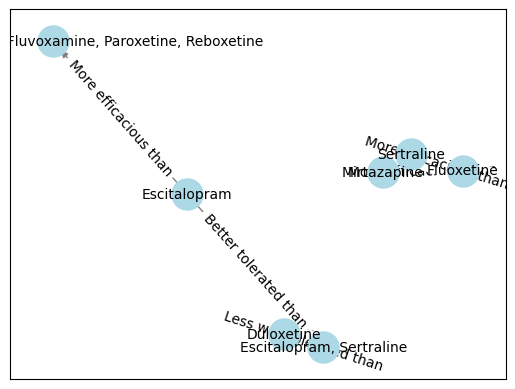

In [ ]:
#Graph w/o localhost
g=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos=g, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos=g, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos=g, font_size=10, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos=g, edge_labels={(u, v): d['relationship'] for u, v, d in G.edges(data=True)})
plt.axis('off')
plt.show()

In [ ]:
!pip install pyvis
from pyvis.network import Network

net = Network(notebook=True, directed=True)

for node, data in G.nodes(data=True):
    net.add_node(node, label=node, title=f"Type: {data['type']}")

for source, target, data in G.edges(data=True):
    net.add_edge(source, target,  label=data.get('relationship', 'N/A'),title=data['relationship'])

net

<class 'pyvis.network.Network'> |N|=7 |E|=5

In [ ]:
!git branch main

In [ ]:
!pwd

/content


In [ ]:

!git add /content/
!git remote add origin "https://github.com/rishikasrinivas/KnowledgeGraphMentalHealth.git"
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git commit -m "GPT code w/ trial kg"
!git push -u origin main

fatal: pathspec 'Brightside' did not match any files
error: remote origin already exists.
On branch master
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	KnowledgeGraphMentalHealth/

nothing added to commit but untracked files present (use "git add" to track)
fatal: could not read Username for 'https://github.com': No such device or address
